In [2]:
# Import necessary libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt   # plotting
import seaborn as sns   # plotting heatmap

Loading Data and EDA

In [3]:
data = pd.read_csv("/Users/welpp/Desktop/Practical Data Science/Data/Data Main/goes_13to18.csv",
                   parse_dates=['time'],
                   index_col='time')

In [17]:
data = data[['xrsa_flux', 'xrsb_flux', 'status', 'Sat']]

In [18]:
data.head()

,xrsa_flux,xrsb_flux,status,Sat
time,,,,
2009-09-01 03:59:00+00:00,1.000000e-09,1.000000e-09,0,14
2009-09-01 04:00:00+00:00,1.000000e-09,1.000000e-09,0,14
2009-09-01 04:01:00+00:00,1.000000e-09,1.000000e-09,0,14
2009-09-01 04:02:00+00:00,1.000000e-09,1.000000e-09,0,14
2009-09-01 04:03:00+00:00,1.000000e-09,1.000000e-09,0,14


In [19]:
data.info

<bound method DataFrame.info of                               xrsa_flux     xrsb_flux  status  Sat
time                                                              
2009-09-01 03:59:00+00:00  1.000000e-09  1.000000e-09       0   14
2009-09-01 04:00:00+00:00  1.000000e-09  1.000000e-09       0   14
2009-09-01 04:01:00+00:00  1.000000e-09  1.000000e-09       0   14
2009-09-01 04:02:00+00:00  1.000000e-09  1.000000e-09       0   14
2009-09-01 04:03:00+00:00  1.000000e-09  1.000000e-09       0   14
...                                 ...           ...     ...  ...
2023-10-02 11:55:00+00:00  1.929477e-09  9.619084e-07       0   18
2023-10-02 11:56:00+00:00  1.000000e-09  9.546236e-07       0   18
2023-10-02 11:57:00+00:00  1.000000e-09  9.511839e-07       0   18
2023-10-02 11:58:00+00:00  1.000000e-09  9.479994e-07       0   18
2023-10-02 11:59:00+00:00  3.127326e-09  9.438966e-07       0   18

[7203583 rows x 4 columns]>

KeyboardInterrupt: 

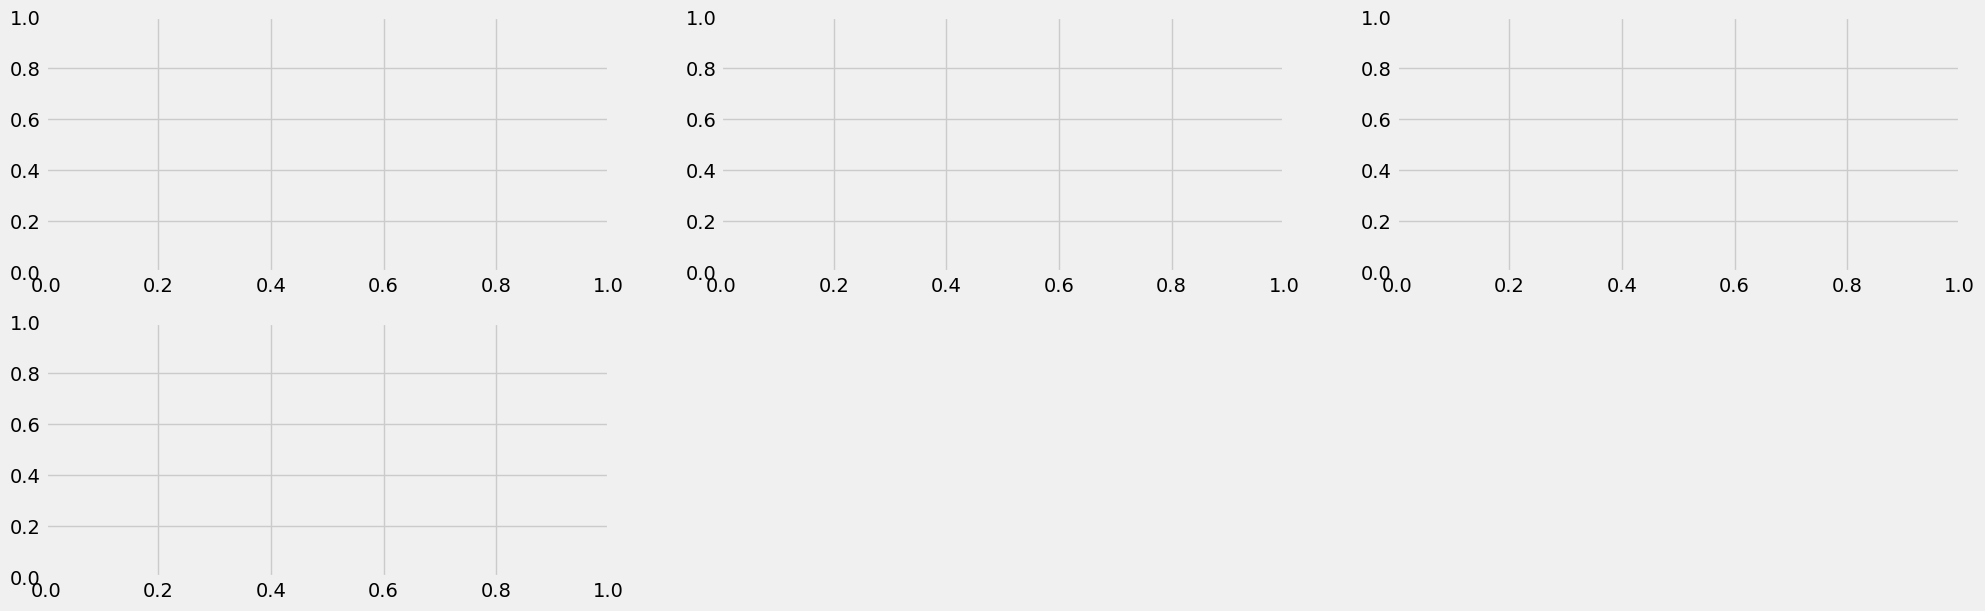

In [6]:
plt.style.use('fivethirtyeight')
data.plot(subplots=True,
        layout=(6, 3),
        figsize=(22,22),
        fontsize=10, 
        linewidth=2,
        sharex=False,
        title='Visualization of the original Time Series')
plt.show()

In [14]:
data[:'2022'].tail()

,xrsa_flux,xrsb_flux,status,flare_class,Sat
time,,,,,
2022-12-31 23:55:00+00:00,4.996568e-09,9.522558e-07,0,NaN,18
2022-12-31 23:56:00+00:00,6.151049e-09,9.515520e-07,0,NaN,18
2022-12-31 23:57:00+00:00,6.601901e-09,9.547597e-07,0,NaN,18
2022-12-31 23:58:00+00:00,7.335534e-09,9.572365e-07,0,NaN,18
2022-12-31 23:59:00+00:00,8.484495e-09,9.689676e-07,0,NaN,18


In [34]:
data['2023-01-09 06:49':'2023-01-09 06:51']

,xrsa_flux,xrsb_flux,status,Sat
time,,,,
2023-01-09 06:49:00+00:00,0.000057,0.000185,0,18
2023-01-09 06:50:00+00:00,0.000060,0.000195,0,18
2023-01-09 06:51:00+00:00,0.000053,0.000179,0,18


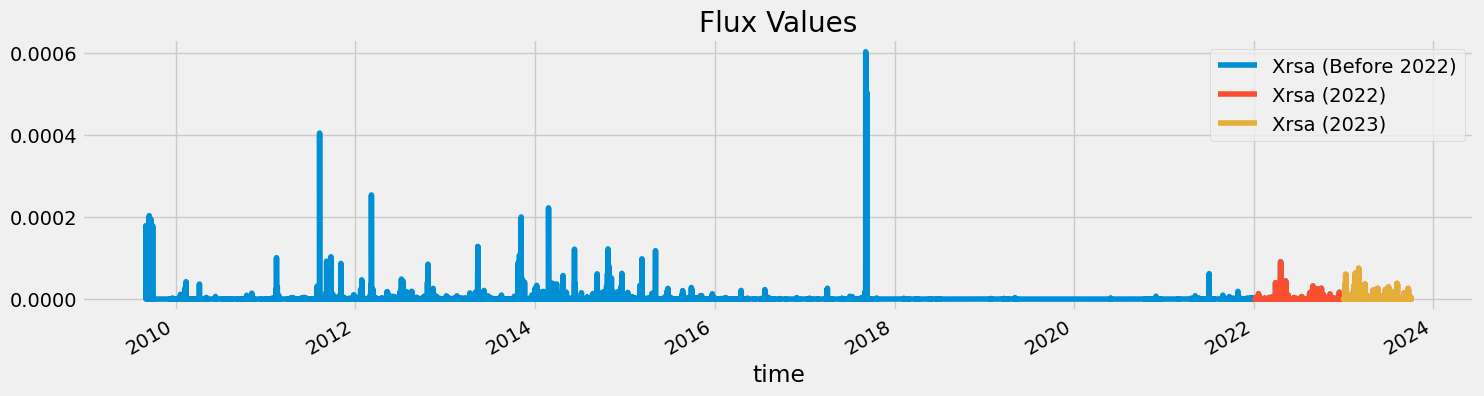

In [12]:
# We have chosen 'High' attribute for prices. Let's see what it looks like
data['xrsa_flux'][:'2022'].plot(figsize=(16,4),legend=True)
data['xrsa_flux']['2022':'2023'].plot(figsize=(16,4),legend=True)
data['xrsa_flux']['2023':].plot(figsize=(16,4),legend=True)
plt.legend(['Xrsa (Before 2022)','Xrsa (2022)', 'Xrsa (2023)'])
plt.title('Flux Values')
plt.show()

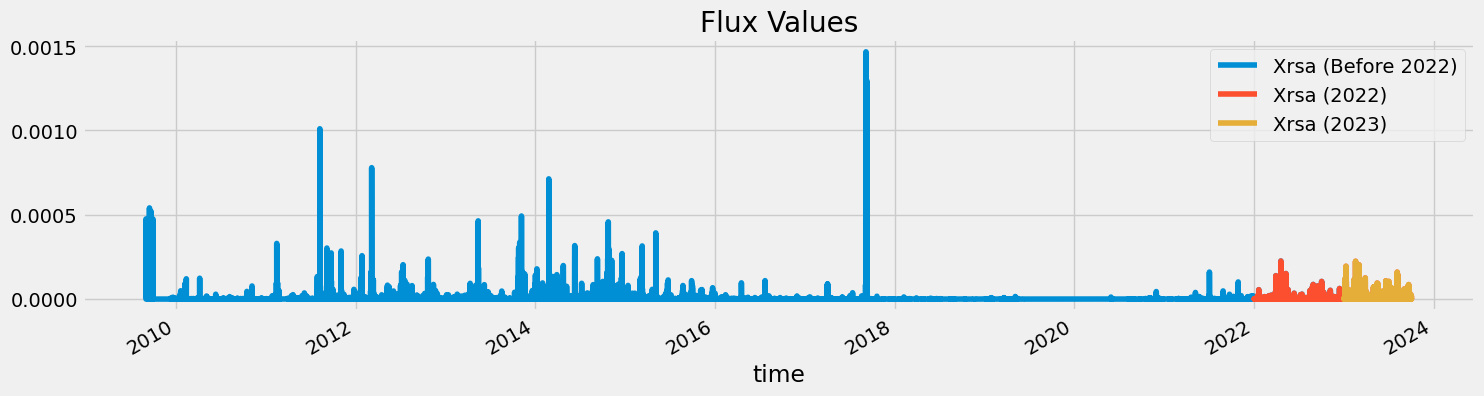

In [8]:
data['xrsb_flux'][:'2022'].plot(figsize=(16,4),legend=True)
data['xrsb_flux']['2022':'2023'].plot(figsize=(16,4),legend=True)
data['xrsb_flux']['2023':].plot(figsize=(16,4),legend=True)
plt.legend(['Xrsa (Before 2022)','Xrsa (2022)', 'Xrsa (2023)'])
plt.title('Flux Values')
plt.show()

Text(0, 0.5, 'xrsb_flux')

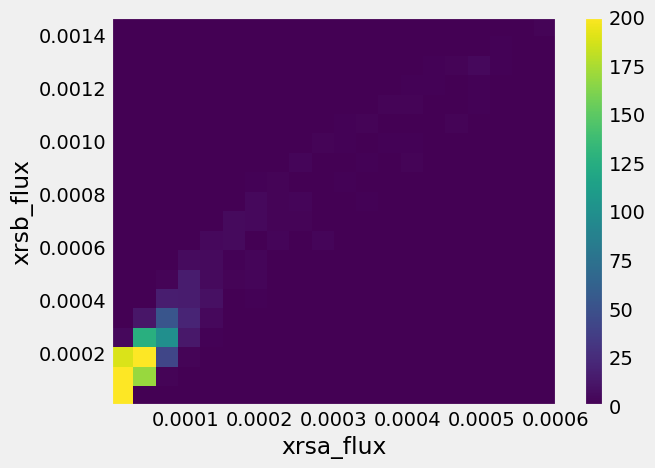

In [20]:
plt.hist2d(data['xrsa_flux'], data['xrsb_flux'], bins=(20, 20), vmax=200)
plt.colorbar()
plt.xlabel('xrsa_flux')
plt.ylabel('xrsb_flux')

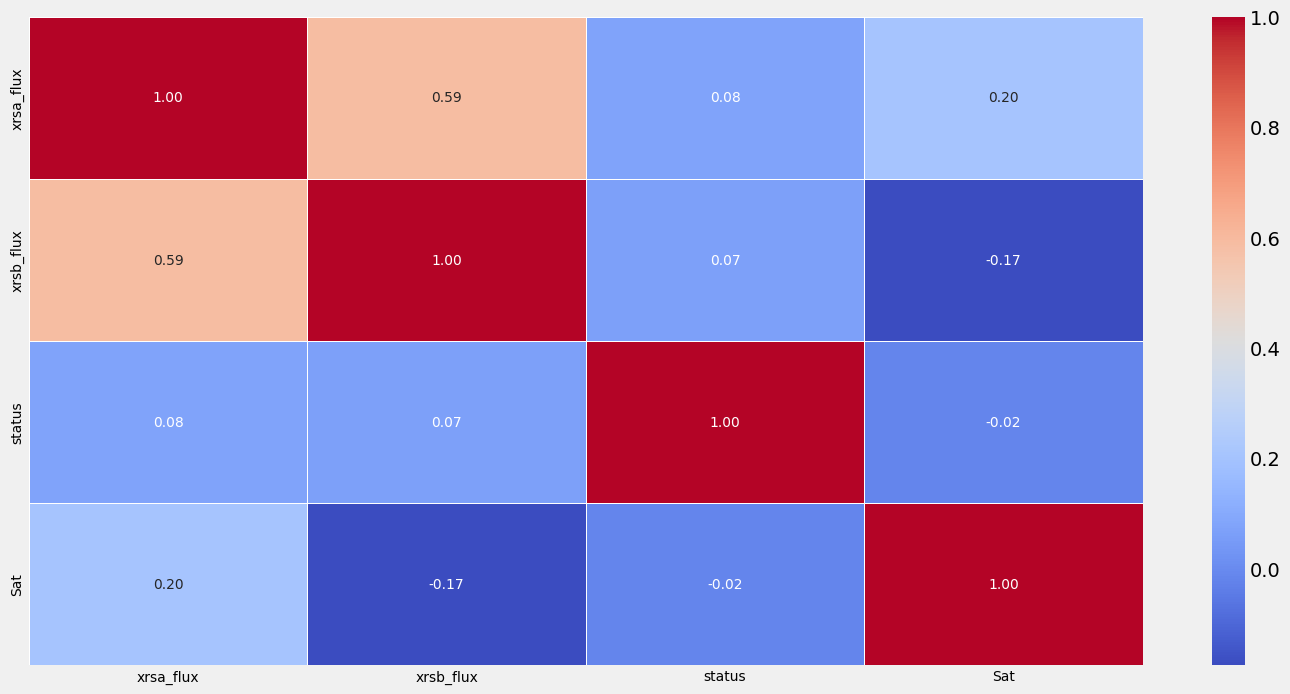

In [21]:
corr_matrix = data.corr(method='spearman')
f, ax = plt.subplots(figsize=(16,8))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', linewidth=0.4,
            annot_kws={"size": 10}, cmap='coolwarm', ax=ax)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

In [ ]:
Data Processing

In [22]:
from sklearn.preprocessing import MinMaxScaler

In [42]:
df = data.copy()

In [36]:
flux = df[['xrsa_flux','xrsb_flux']]

In [37]:
## minmax scaling flux values only
scaler = MinMaxScaler(feature_range=(0, 1))
flux = scaler.fit_transform(flux)

In [38]:
df = pd.concat([df, pd.DataFrame(flux)], axis = 1)
df = df[[0, 1, 'status']]
df.columns = ['xrsa_flux', 'xrsb_flux', 'status']

In [43]:
df.head()

,xrsa_flux,xrsb_flux,status,Sat
time,,,,
2009-09-01 03:59:00+00:00,1.000000e-09,1.000000e-09,0,14
2009-09-01 04:00:00+00:00,1.000000e-09,1.000000e-09,0,14
2009-09-01 04:01:00+00:00,1.000000e-09,1.000000e-09,0,14
2009-09-01 04:02:00+00:00,1.000000e-09,1.000000e-09,0,14
2009-09-01 04:03:00+00:00,1.000000e-09,1.000000e-09,0,14


In [40]:
df.head()

,xrsa_flux,xrsb_flux,status
2009-09-01 03:59:00+00:00,NaN,NaN,0.0
2009-09-01 04:00:00+00:00,NaN,NaN,0.0
2009-09-01 04:01:00+00:00,NaN,NaN,0.0
2009-09-01 04:02:00+00:00,NaN,NaN,0.0
2009-09-01 04:03:00+00:00,NaN,NaN,0.0


In [39]:
## data splits
train = df[:'2022']
val = df['2022':'2023']
test = df['2023':]

KeyError: '2022'

In [ ]:
X_lstm = []
y_lstm = []

for i in range(len(X) - timesteps):
    X_lstm.append(X[i:i + timesteps, :])
    y_lstm.append(y[i + timesteps])